# Creating a Neural Network for Classification 

In this notebook, we'll learn how to create a neural network for multi-categorical classification using the Iris dataset. This is the same dataset that was explored in the Logistic Regression notebook, but now using an entirely different models. The ideas are the same, however, so if you'd like extra support refer back to the Logistic Regression notebook where concepts like loss and optimization are broken down a bit more.


We'll start off by importing some libraries that will be helpful for us to build out our model. `sklearn` (scikitlearn) is another helpful machine learning-related library, and will be where we get the Iris dataset from.

In [1]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
import json
import os
import sys

from IPython.core.display import HTML, display
# Initializing D3 for the entire notebook (this fixes error requiring kernel to load twice)
# (feel free to move this line to anywhere in notebook before visualizations)
display(HTML('<script data-require="d3@3.5.3" data-semver="3.5.3" src="//cdnjs.cloudflare.com/ajax/libs/d3/3.5.3/d3.js"></script>'))

## Load the dataset

The Iris flower dataset is available on the [Keras dataset API](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) if you'd like to see the raw HTML.

The following code loads the Iris dataset onto this notebook. We'll peek at what this dataset looks like.

In [2]:
iris = datasets.load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris = iris.astype({"target": int })

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
# # rendering d3 vector visualization
# from IPython.core.display import display, HTML

# display(HTML(filename='./libraries/iris.html'))

## Explore the data 

Let's take a moment to understand the format of the data. Each data contains sepal length, sepal width, petal length, petal width and a corresponding species label. The label is an integer value of either 0, 1, or 2 where 0 is a `Iris-setosa`, 1 is a `Iris-versicolo`, and 2 is a `Iris-virginica.`

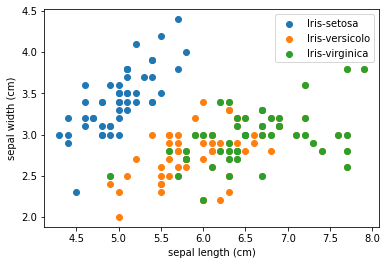

In [4]:
plt.scatter(iris['sepal length (cm)'][:50], iris['sepal width (cm)'][:50], label='Iris-setosa')
plt.scatter(iris['sepal length (cm)'][51:], iris['sepal width (cm)'][51:], label='Iris-versicolo')
plt.scatter(iris['sepal length (cm)'][101:], iris['sepal width (cm)'][101:], label='Iris-virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(loc='best')

The following two code blocks help us set up our data to use as input into our neural network model. You can refer back to the Logistic Regression notebook for an explanation on encoding our data.

In [5]:
x = iris.drop(labels=['target'], axis=1).values
y_ = iris['target'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

Here, we're splitting the whole Iris dataset into a training set and a test set. The training set is a bit smaller than our test set, containing 20% of the original dataset while the other 80% will be used in testing our model. 

Feel free to change these values and see how the accuracy and loss of our model changes later down the road.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

x, y = shuffle(x, y)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.8)

## Building our neural network 

Finally, we can start to build a simple neural network. We'll use Tensorflow Keras to build our model. 

Overall, we have 4 layers to our neural network. The first layer is the input layer that we've named aptly. The activation function is the ReLU (Rectified Linear Unit) function, which is commonly used for neural networks. The input shape is `(4,),` representing the four features (sepal length, sepal width, petal length, petal width) we're interested in looking at to classify which Iris category the current array represents. 

Next, we have two "hidden layers," or two layers sandwiched between our input and output layer. They also have a ReLU activation function. These hidden layers help the neural network break down the incoming data into unique parts to help the whole neural network better understand how to classify the piece of data. 

Lastly, we have the output layer. There are three nodes in our output layer, alongside a new activation function (`softmax`). `Softmax` helps to normalize our output probability in the 0-1 range so we can understand the output of our function better. Because we are using `softmax,` we need one node per category label. 

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,), name='input'),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu, name='hidden-1'),
  tf.keras.layers.Dense(10, activation=tf.nn.relu, name='hidden-2'),
  tf.keras.layers.Dense(3, activation='softmax', name='output')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                50        
_________________________________________________________________
hidden-1 (Dense)             (None, 10)                110       
_________________________________________________________________
hidden-2 (Dense)             (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
None


We can see what the output of our hidden layers looks like. The whole `predictions` array holds an array of vectors, where each vector is the hidden layers' probability calculations. The index of the array (0, 1, or 2) represents the calculated probability that the inputted data corresponds to that category of Iris, where 0 is a `Iris-setosa`, 1 is a `Iris-versicolo`, and 2 is a `Iris-virginica.`

In [8]:
# Hidden Layer Vector
predictions = model(x)
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.29139283, 0.32101235, 0.38759476],
       [0.28970033, 0.30173993, 0.40855968],
       [0.2953273 , 0.30308816, 0.40158454],
       [0.2886811 , 0.3421104 , 0.3692085 ],
       [0.29976818, 0.30722177, 0.39301002]], dtype=float32)>

## Train the model

The next step is to train our model. We'll use a built-in optimizer to optimize our model with stochastic gradient descent (SGD), updating the parameters in our neural network through backpropogation. Backpropogation is essentially seeing our neural network reacts to changing the weights and biases within our model. Understanding the math behind backpropogation is more math-heavy, so we won't cover it too in-depth here. Refer to the site for more detail. 

We've also chosen to use a built-in a loss function (categorical cross-entropy loss). Cross-entropy loss, shown in the Logisitic Regression notebook, is used for binary classification while categorical cross-entropy loss is for multi-categorical classification such as this iris problem (we have three different classes). 

Feel free to play around with different optimizers and loss functions. You can find the full documentation on the Tensorflow site: [optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) and [loss functions](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

In [9]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Initializing the Extractor module
import libraries.extractioncallback as excb

extractor = excb.CallbackDataExtractor(
    model = model,
    layer = 1,
    validation_data = (test_x, test_y),
    sample_every = 10,
    rec_int_values = True,
    is_bin = False
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                50        
_________________________________________________________________
hidden-1 (Dense)             (None, 10)                110       
_________________________________________________________________
hidden-2 (Dense)             (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [10]:
hist = model.fit(train_x, train_y, verbose=1, batch_size=32, epochs=200, validation_split=0.3, callbacks=[extractor])

Epoch 1/200
1/1 [==============================] - 1s 932ms/step - loss: 1.0777 - accuracy: 0.4286 - val_loss: 1.0723 - val_accuracy: 0.3333
Epoch 2/200
1/1 [==============================] - 0s 201ms/step - loss: 1.0577 - accuracy: 0.3810 - val_loss: 1.0609 - val_accuracy: 0.3333
Epoch 3/200
1/1 [==============================] - 0s 206ms/step - loss: 1.0452 - accuracy: 0.3810 - val_loss: 1.0532 - val_accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 197ms/step - loss: 1.0381 - accuracy: 0.3810 - val_loss: 1.0484 - val_accuracy: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 189ms/step - loss: 1.0332 - accuracy: 0.4286 - val_loss: 1.0438 - val_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 226ms/step - loss: 1.0286 - accuracy: 0.4286 - val_loss: 1.0396 - val_accuracy: 0.3333
Epoch 7/200
1/1 [==============================] - 0s 207ms/step - loss: 1.0247 - accuracy: 0.4286 - val_loss: 1.0354 - val_accuracy: 0.3333
Epoch 8/200
1

1/1 [==============================] - 0s 248ms/step - loss: 0.8920 - accuracy: 0.4286 - val_loss: 0.9058 - val_accuracy: 0.3333
Epoch 49/200
1/1 [==============================] - 0s 216ms/step - loss: 0.8893 - accuracy: 0.4286 - val_loss: 0.9015 - val_accuracy: 0.3333
Epoch 50/200
1/1 [==============================] - 0s 234ms/step - loss: 0.8866 - accuracy: 0.4286 - val_loss: 0.9016 - val_accuracy: 0.3333
Epoch 51/200
1/1 [==============================] - 0s 188ms/step - loss: 0.8838 - accuracy: 0.4286 - val_loss: 0.8984 - val_accuracy: 0.3333
Epoch 52/200
1/1 [==============================] - 0s 190ms/step - loss: 0.8809 - accuracy: 0.4286 - val_loss: 0.8955 - val_accuracy: 0.3333
Epoch 53/200
1/1 [==============================] - 0s 194ms/step - loss: 0.8784 - accuracy: 0.4286 - val_loss: 0.8963 - val_accuracy: 0.3333
Epoch 54/200
1/1 [==============================] - 0s 212ms/step - loss: 0.8763 - accuracy: 0.4286 - val_loss: 0.8903 - val_accuracy: 0.3333
Epoch 55/200
1/1 [=

1/1 [==============================] - 0s 157ms/step - loss: 0.7613 - accuracy: 0.4762 - val_loss: 0.7833 - val_accuracy: 0.4444
Epoch 96/200
1/1 [==============================] - 0s 194ms/step - loss: 0.7570 - accuracy: 0.5714 - val_loss: 0.7867 - val_accuracy: 0.4444
Epoch 97/200
1/1 [==============================] - 0s 149ms/step - loss: 0.7541 - accuracy: 0.5238 - val_loss: 0.7763 - val_accuracy: 0.4444
Epoch 98/200
1/1 [==============================] - 0s 182ms/step - loss: 0.7519 - accuracy: 0.6190 - val_loss: 0.7844 - val_accuracy: 0.4444
Epoch 99/200
1/1 [==============================] - 0s 194ms/step - loss: 0.7495 - accuracy: 0.5238 - val_loss: 0.7715 - val_accuracy: 0.4444
Epoch 100/200
1/1 [==============================] - 0s 210ms/step - loss: 0.7456 - accuracy: 0.6667 - val_loss: 0.7783 - val_accuracy: 0.4444
Epoch 101/200
1/1 [==============================] - 0s 178ms/step - loss: 0.7435 - accuracy: 0.5714 - val_loss: 0.7655 - val_accuracy: 0.5556
Epoch 102/200
1/1

1/1 [==============================] - 0s 190ms/step - loss: 0.6082 - accuracy: 0.9048 - val_loss: 0.6426 - val_accuracy: 0.7778
Epoch 142/200
1/1 [==============================] - 0s 242ms/step - loss: 0.6050 - accuracy: 0.8571 - val_loss: 0.6262 - val_accuracy: 0.7778
Epoch 143/200
1/1 [==============================] - 0s 182ms/step - loss: 0.6014 - accuracy: 0.9048 - val_loss: 0.6341 - val_accuracy: 0.7778
Epoch 144/200
1/1 [==============================] - 0s 125ms/step - loss: 0.5981 - accuracy: 0.8571 - val_loss: 0.6197 - val_accuracy: 0.8889
Epoch 145/200
1/1 [==============================] - 0s 177ms/step - loss: 0.5955 - accuracy: 1.0000 - val_loss: 0.6273 - val_accuracy: 0.7778
Epoch 146/200
1/1 [==============================] - 0s 187ms/step - loss: 0.5916 - accuracy: 0.8571 - val_loss: 0.6187 - val_accuracy: 0.7778
Epoch 147/200
1/1 [==============================] - 0s 195ms/step - loss: 0.5880 - accuracy: 0.8571 - val_loss: 0.6181 - val_accuracy: 0.7778
Epoch 148/200

1/1 [==============================] - 0s 186ms/step - loss: 0.4680 - accuracy: 1.0000 - val_loss: 0.4969 - val_accuracy: 1.0000
Epoch 188/200
1/1 [==============================] - 0s 189ms/step - loss: 0.4648 - accuracy: 1.0000 - val_loss: 0.4988 - val_accuracy: 1.0000
Epoch 189/200
1/1 [==============================] - 0s 165ms/step - loss: 0.4622 - accuracy: 1.0000 - val_loss: 0.4903 - val_accuracy: 1.0000
Epoch 190/200
1/1 [==============================] - 0s 136ms/step - loss: 0.4590 - accuracy: 1.0000 - val_loss: 0.4902 - val_accuracy: 1.0000
Epoch 191/200
1/1 [==============================] - 0s 140ms/step - loss: 0.4559 - accuracy: 1.0000 - val_loss: 0.4862 - val_accuracy: 1.0000
Epoch 192/200
1/1 [==============================] - 0s 198ms/step - loss: 0.4530 - accuracy: 1.0000 - val_loss: 0.4871 - val_accuracy: 1.0000
Epoch 193/200
1/1 [==============================] - 0s 180ms/step - loss: 0.4504 - accuracy: 1.0000 - val_loss: 0.4784 - val_accuracy: 1.0000
Epoch 194/200

There are two graphs below to demonstrate the relationship between accuracy, loss, and our epoch. What trend do you generally notice here? 

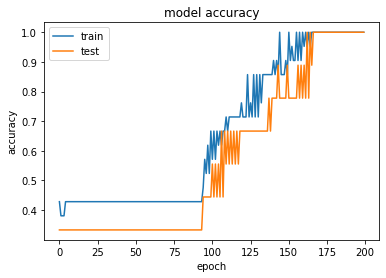

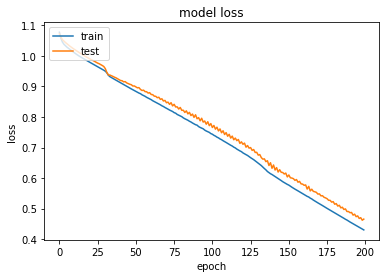

In [11]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Evaluate the model

Now, let's see how the model performs on our test data set after the model has been trained. Two values will be returned: the loss of our model (a number which represents our error -- lower values are better), and the accuracy of our model. You can try adjusting the batch size too to see how it affects the model's loss and accuracy.

In [12]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# make a prediction
testingPredictions = model.predict(test_x)
testingPredictions = list(testingPredictions.argmax(axis=-1))

confidence_scores = model.predict(test_x, batch_size=32)
# print(confidence_scores)

target_names = ['Iris-setosa', 'Iris-versicolo', 'Iris-virginica']
print(classification_report(test_y.argmax(axis=-1), testingPredictions, target_names=target_names))

                precision    recall  f1-score   support

   Iris-setosa       1.00      1.00      1.00        43
Iris-versicolo       1.00      0.77      0.87        39
Iris-virginica       0.81      1.00      0.89        38

      accuracy                           0.93       120
     macro avg       0.94      0.92      0.92       120
  weighted avg       0.94      0.93      0.92       120



In [13]:
results = model.evaluate(test_x, test_y, verbose=1)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

4/4 [==============================] - 0s 6ms/step - loss: 0.5366 - accuracy: 0.9250
loss: 0.537
accuracy: 0.925


Now, we need to export the data in order to support some interactive visualizations that we've created. Feel free to skip over this code block and move to the interactive visualizations below.

In [14]:
import json, os, sys

output_directory = "libraries/stored_results/"
output_filename = "neural_network_class.json"
full_path = os.path.join(output_directory, output_filename)

epoch_output = extractor.get_testing_results()
extractor.generateJSON(path=full_path)

In [15]:
import libraries.mlvislib as mlvs

cm = mlvs.ConfusionMatrix(full_path, x_labels=["Setosa", "Veriscolo", "Virginica"], y_labels=["Virginica", "Veriscolo", "Setosa"])
cm.display()

In [16]:
import libraries.barcode as bc

bp = bc.BarcodePlot(full_path)
bp.display()